# RNN Time Series Forecasting

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import math
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from keras import callbacks
import pickle


In [6]:
PATH = r"../../Data/completeLoad.csv"
df = pd.read_csv(PATH)
temp = df.set_index(['zone_id', 'year', 'month', 'day'])

colname_to_int = {}
for i in list(temp.columns):
    colname_to_int[i] = int(i[1:])

temp = temp.rename(columns=trans_dict)
temp = temp.stack()
temp = temp.unstack(level=0)
temp.columns.names = [None]
temp.index.names = [None, None, None, None]
df_zone = temp
temp.head(2)

NameError: name 'trans_dict' is not defined

In [ ]:
df_zone.plot(subplots=True, layout=(4,5), figsize = (20,10))

In [ ]:
plt.figure(figsize = (30, 15))
for i, x in enumerate(df_zone):
    plt.subplot(5, 4, i+1)
    plt.subplots_adjust(wspace=0.2, hspace=0.6)
    plt.plot(df_zone[x].values)
    plt.xlabel("Time (hours)")
    plt.ylabel("Load (MWh)")
    plt.title("Zone {} Load, 2004-2008".format(i+1))
plt.show()

In [ ]:
# use data for zone 1.
data = df_zone[1].values.reshape(-1, 1)

# normalize data with min max normalization.
normalizer = MinMaxScaler(feature_range = (0, 1))
dataset = normalizer.fit_transform(data)

# Using 80% of data for training, 20% for validation.
TRAINING_PERC = 0.80

train_size = int(len(dataset) * TRAINING_PERC)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print("Number of samples training set: " + str((len(train))))
print("Number of samples test set: " + str((len(test))))

In [475]:
# helper function to read data.
def create_dataset(dataset, window_size = 1):
    data_x, data_y = [], []
    for i in range(len(dataset) - window_size - 1):
        sample = dataset[i:(i + window_size), 0]
        data_x.append(sample)
        data_y.append(dataset[i + window_size, 0])
    return(np.array(data_x), np.array(data_y))

def create_model(train_X, train_Y, window_size = 1):
    vanilla_rnn = Sequential()
    vanilla_rnn.add(LSTM(5,input_shape = (1, window_size), ))
    vanilla_rnn.add(Dense(1))
    vanilla_rnn.compile(loss = "mean_squared_error", optimizer = "adam", 
                        metrics = ['mse', 'mae'])
    
    return(vanilla_rnn)

def create_model2(train_X, train_Y, window_size = 1, nstep = 1):
    vanilla_rnn = Sequential()
    vanilla_rnn.add(LSTM(200, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
    vanilla_rnn.add(LSTM(200))
    vanilla_rnn.add(Dense(nstep))
    vanilla_rnn.compile(loss = "mean_squared_error", optimizer = "adam", metrics = ['mse', 'mae', 'mape'])
    return(vanilla_rnn)

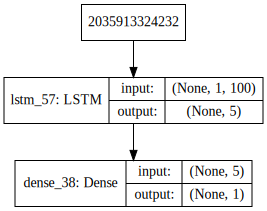

In [487]:
window_size = 100
train_X, train_Y = create_dataset(train, window_size)
test_X, test_Y = create_dataset(test, window_size)
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

vanilla_rnn = create_model(train_X, train_Y, window_size)
SVG(model_to_dot(vanilla_rnn, show_shapes=True).create(prog='dot', format='svg'))

In [489]:
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = vanilla_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.15, 
                          callbacks=[es])

Train on 26825 samples, validate on 4734 samples
Epoch 1/100
 - 23s - loss: 5.3723e-04 - mean_squared_error: 5.3723e-04 - mean_absolute_error: 0.0172 - val_loss: 5.9684e-04 - val_mean_squared_error: 5.9684e-04 - val_mean_absolute_error: 0.0183
Epoch 2/100
 - 26s - loss: 4.5904e-04 - mean_squared_error: 4.5904e-04 - mean_absolute_error: 0.0159 - val_loss: 5.6357e-04 - val_mean_squared_error: 5.6357e-04 - val_mean_absolute_error: 0.0180
Epoch 3/100
 - 21s - loss: 4.1948e-04 - mean_squared_error: 4.1948e-04 - mean_absolute_error: 0.0152 - val_loss: 5.7937e-04 - val_mean_squared_error: 5.7937e-04 - val_mean_absolute_error: 0.0180
Epoch 4/100
 - 20s - loss: 3.9667e-04 - mean_squared_error: 3.9667e-04 - mean_absolute_error: 0.0148 - val_loss: 5.3518e-04 - val_mean_squared_error: 5.3518e-04 - val_mean_absolute_error: 0.0174
Epoch 5/100
 - 20s - loss: 3.7652e-04 - mean_squared_error: 3.7652e-04 - mean_absolute_error: 0.0144 - val_loss: 4.2378e-04 - val_mean_squared_error: 4.2378e-04 - val_mean

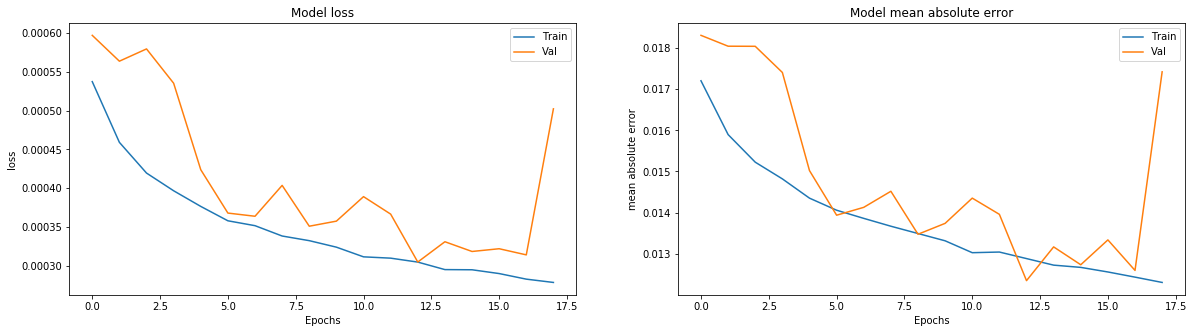

In [490]:
metrics = [['loss', 'val_loss'], ['mean_absolute_error', 
           'val_mean_absolute_error']]

plt.figure(figsize = (20, 5))
for i, x in enumerate(metrics):
    plt.subplot(1, 2, i+1)
    plt.plot(history.history[x[0]])
    plt.plot(history.history[x[1]])
    plt.legend(['Train', 'Val'], loc='best')
    string_metric = (' ').join(x[0].split('_'))
    plt.xlabel("Epochs")
    plt.title('Model {}'.format(string_metric))
    plt.ylabel(string_metric)
plt.show()

In [491]:
def get_predict_and_score(model, X, Y):
    # transform the prediction to the original scale.
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability.
    orig_data =normalizer.inverse_transform([Y])
    # calculate RMSE.
    score = math.sqrt(mean_squared_error(orig_data[0], pred[:, 0]))
    return(score, pred)

def get_naive_hour_predict_and_score(X, Y):
    # transform the prediction to the original scale.
    pred = normalizer.inverse_transform(np.hstack((Y[0], Y[0:-1])).reshape(-1, 1))
    # transform also the label to the original scale for interpretability.
    orig_data =normalizer.inverse_transform([Y])
    # calculate RMSE.
    score = math.sqrt(mean_squared_error(orig_data[0], pred[:, 0]))
    return(score, pred)

def get_naive_day_predict_and_score(X, Y):
    # transform the prediction to the original scale.
    pred = normalizer.inverse_transform(np.hstack((Y[0:24], Y[0:-24])).reshape(-1, 1))
    # transform also the label to the original scale for interpretability.
    orig_data =normalizer.inverse_transform([Y])
    # calculate RMSE.
    score = math.sqrt(mean_squared_error(orig_data[0], pred[:, 0]))
    return(score, pred)

def get_naive_week_predict_and_score(X, Y):
    # transform the prediction to the original scale.
    pred = normalizer.inverse_transform(np.hstack((Y[0:24*7], Y[0:-24*7])).reshape(-1, 1))
    # transform also the label to the original scale for interpretability.
    orig_data =normalizer.inverse_transform([Y])
    # calculate RMSE.
    score = math.sqrt(mean_squared_error(orig_data[0], pred[:, 0]))
    return(score, pred)

mse_train, train_predict = get_predict_and_score(vanilla_rnn, train_X, train_Y)
mse_test, test_predict = get_predict_and_score(vanilla_rnn, test_X, test_Y)
mse_train_naive_hour, train_predict_naive_hour = get_naive_hour_predict_and_score(train_X, train_Y)
mse_test_naive_hour, test_predict_naive_hour = get_naive_hour_predict_and_score(test_X, test_Y)
mse_train_naive_day, train_predict_naive_day = get_naive_day_predict_and_score(train_X, train_Y)
mse_test_naive_day, test_predict_naive_day = get_naive_day_predict_and_score(test_X, test_Y)
mse_train_naive_week, train_predict_naive_week = get_naive_week_predict_and_score(train_X, train_Y)
mse_test_naive_week, test_predict_naive_week = get_naive_week_predict_and_score(test_X, test_Y)

print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
print("(Naive -1 hour) Training data error: %.2f MSE" % mse_train_naive_hour)
print("(Naive -1 hour) Test data error: %.2f MSE" % mse_test_naive_hour)
print("(Naive -1 day) Training data error: %.2f MSE" % mse_train_naive_day)
print("(Naive -1 day) Test data error: %.2f MSE" % mse_test_naive_day)
print("(Naive -1 week) Training data error: %.2f MSE" % mse_train_naive_week)
print("(Naive -1 week) Test data error: %.2f MSE" % mse_test_naive_week)

Training data error: 789.13 MSE
Test data error: 832.34 MSE
(Naive -1 hour) Training data error: 1445.17 MSE
(Naive -1 hour) Test data error: 1493.20 MSE
(Naive -1 day) Training data error: 3022.67 MSE
(Naive -1 day) Test data error: 3284.73 MSE
(Naive -1 week) Training data error: 4528.71 MSE
(Naive -1 week) Test data error: 5281.45 MSE


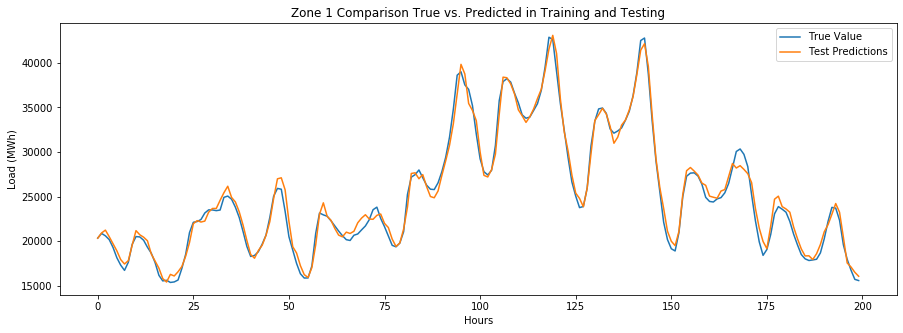

In [314]:
# Training predictions.
train_predictions = np.empty_like(dataset)
train_predictions[:, :] = np.nan
train_predictions[window_size:len(train_predict) + window_size, :] = train_predict

# Test predictions.
test_predictions = np.empty_like(dataset)
test_predictions[:, :] = np.nan
test_predictions[len(train_predict) + (window_size * 2) + 1:len(dataset) - 1, :] = test_predict

# Create the plot.
plt.figure(figsize = (15, 5))
plt.plot(normalizer.inverse_transform(dataset)[35000:35200], label = "True Value")
#plt.plot(train_predictions, label = "Training Predictions")
plt.plot(test_predictions[35000:35200], label = "Test Predictions")
plt.xlabel("Hours")
plt.ylabel("Load (MWh)")
plt.title("Zone 1 Comparison True vs. Predicted in Training and Testing")
plt.legend()
plt.show()

In [302]:
len(dataset)

39576

In [315]:
test_predictions=test_predictions.reshape(1,-1)
print(test_predictions)
path = r'../../Data/lstm_predictor_window100_0_39575_.csv'
if not os.path.exists(path):
    np.savetxt(path, (test_predictions), delimiter=',')


[[           nan            nan            nan ... 22506.9609375
  20690.99804688            nan]]


## N-day Forecasting

In [394]:
from keras.layers import Conv1D, MaxPooling1D, Flatten, TimeDistributed
import keras.backend as K
# helper function to read data.
def create_dataset_nstep(dataset, window_size = 1, nstep = 1):
    data_x, data_y = [], []
    for i in range(len(dataset) - window_size - nstep - 1):
        sample = dataset[i:(i + window_size), 0]
        data_x.append(sample)
        data_y.append(dataset[(i + window_size):(i + window_size + nstep), 0])
    return(np.array(data_x), np.array(data_y))

def create_model_nstep(train_X, train_Y, window_size = 1, nstep = 1):
    vanilla_rnn = Sequential()
    vanilla_rnn.add(LSTM(200, return_sequences=True))
    vanilla_rnn.add(LSTM(209))
    vanilla_rnn.add(Dense(nstep))
    vanilla_rnn.compile(loss = "mean_squared_error", 
                  optimizer = "adam", metrics = ['mse', 'mae', 'mape'])

    return(vanilla_rnn)


    return(vanilla_rnn)

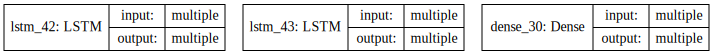

In [419]:
window_size = 100
nstep = 24
train_X, train_Y = create_dataset_nstep(train, window_size, nstep)
test_X, test_Y = create_dataset_nstep(test, window_size, nstep)
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

multi_rnn = create_model_nstep(train_X, train_Y, window_size, nstep)
SVG(model_to_dot(multi_rnn, show_shapes=True).create(prog='dot', format='svg'))

In [420]:
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = multi_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 500, verbose = 2, validation_split=0.15, callbacks=[es])

Train on 26804 samples, validate on 4731 samples
Epoch 1/100
 - 13s - loss: 0.0265 - mean_squared_error: 0.0265 - mean_absolute_error: 0.1225 - mean_absolute_percentage_error: 5435.6110 - val_loss: 0.0148 - val_mean_squared_error: 0.0148 - val_mean_absolute_error: 0.0953 - val_mean_absolute_percentage_error: 35.9027
Epoch 2/100
 - 5s - loss: 0.0080 - mean_squared_error: 0.0080 - mean_absolute_error: 0.0687 - mean_absolute_percentage_error: 6626.4739 - val_loss: 0.0079 - val_mean_squared_error: 0.0079 - val_mean_absolute_error: 0.0663 - val_mean_absolute_percentage_error: 23.1967
Epoch 3/100
 - 6s - loss: 0.0054 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0547 - mean_absolute_percentage_error: 4664.9262 - val_loss: 0.0065 - val_mean_squared_error: 0.0065 - val_mean_absolute_error: 0.0592 - val_mean_absolute_percentage_error: 20.2499
Epoch 4/100
 - 6s - loss: 0.0048 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0511 - mean_absolute_percentage_error: 4044.9419 - val_loss

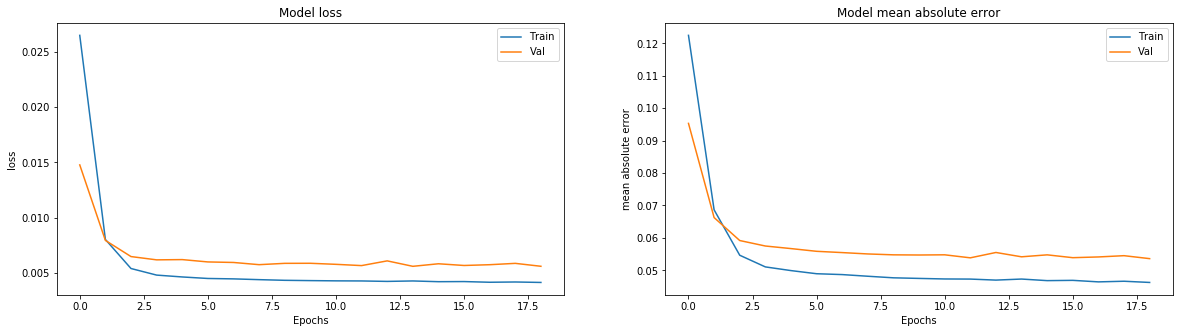

In [421]:
metrics = [['loss', 'val_loss'], ['mean_absolute_error', 
           'val_mean_absolute_error']]#, ['mean_absolute_percentage_error', 'val_mean_absolute_percentage_error']]

plt.figure(figsize = (20, 5))
for i, x in enumerate(metrics):
    plt.subplot(1, 2, i+1)
    plt.plot(history.history[x[0]])
    plt.plot(history.history[x[1]])
    plt.legend(['Train', 'Val'], loc='best')
    string_metric = (' ').join(x[0].split('_'))
    plt.xlabel("Epochs")
    plt.title('Model {}'.format(string_metric))
    plt.ylabel(string_metric)
plt.show()

In [422]:
def get_predict_and_score_multi(model, X, Y):
    # transform the prediction to the original scale
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred))
    return(score, pred)

def get_naive_week_predict_and_score_multi(X, Y):
    # transform the prediction to the original scale.
    pred = normalizer.inverse_transform(np.vstack((Y[0:24*7], Y[0:-24*7])))
    # transform also the label to the original scale for interpretability.
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE.
    score = math.sqrt(mean_squared_error(orig_data, pred))
    return(score, pred)

def get_naive_day_predict_and_score_multi(X, Y):
    # transform the prediction to the original scale.
    pred = normalizer.inverse_transform(np.vstack((Y[0:24], Y[0:-24])))
    # transform also the label to the original scale for interpretability.
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE.
    score = math.sqrt(mean_squared_error(orig_data, pred))
    return(score, pred)

def get_naive_hour_predict_and_score_multi(X, Y):
    # transform the prediction to the original scale.
    pred = normalizer.inverse_transform(np.vstack((Y[0, :].reshape(1, -1), Y[0:-1])))
    # transform also the label to the original scale for interpretability.
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE.
    score = math.sqrt(mean_squared_error(orig_data, pred))
    return(score, pred)

mse_train, train_predict = get_predict_and_score_multi(multi_rnn, train_X, train_Y)
mse_test, test_predict = get_predict_and_score_multi(multi_rnn, test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
mse_train_naive_week, train_predict_naive_week = get_naive_day_predict_and_score_multi(train_X, train_Y)
mse_test_naive_week, test_predict_naive_week = get_naive_day_predict_and_score_multi(test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train_naive_week)
print("Test data error: %.2f MSE" % mse_test_naive_week)

Training data error: 2516.43 MSE
Test data error: 2773.33 MSE
Training data error: 3019.13 MSE
Test data error: 3288.57 MSE


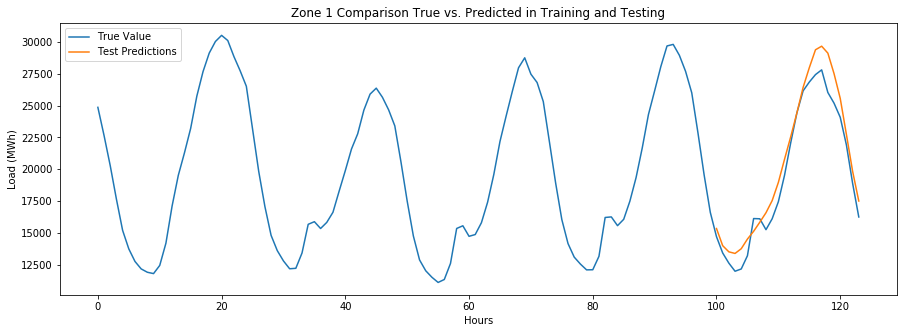

In [426]:
# Create the plot.
plt.figure(figsize = (15, 5))
i = 1000
plt.plot(normalizer.inverse_transform(dataset)[train_size+i:train_size + window_size + nstep + i], label = "True Value")
# plt.plot(train_predictions, label = "Training Predictions")
plt.plot(np.concatenate((np.array([np.nan] * (window_size)), test_predict[i])), label = "Test Predictions")
plt.xlabel("Hours")
plt.ylabel("Load (MWh)")
plt.title("Zone 1 Comparison True vs. Predicted in Training and Testing")
plt.legend()
plt.show()

In [428]:
test_predictions=np.concatenate((np.array([np.nan] * (window_size)), test_predict[i])).reshape(1,-1)
print(test_predictions)
path = r'../../Data/lstm_predictor_24h_window100_32660_32784.csv'
if not os.path.exists(path):
    np.savetxt(path, (test_predictions), delimiter=',')


[[           nan            nan            nan            nan
             nan            nan            nan            nan
             nan            nan            nan            nan
             nan            nan            nan            nan
             nan            nan            nan            nan
             nan            nan            nan            nan
             nan            nan            nan            nan
             nan            nan            nan            nan
             nan            nan            nan            nan
             nan            nan            nan            nan
             nan            nan            nan            nan
             nan            nan            nan            nan
             nan            nan            nan            nan
             nan            nan            nan            nan
             nan            nan            nan            nan
             nan            nan            nan            nan
        

## Multivariate RNN

In [429]:
PATH = r"../../Data/temperature_history.csv"
df_T = pd.read_csv(PATH)
h_df_T = df_T.set_index(['station_id', 'year', 'month', 'day'])
trans_dict = {}
for i in list(h_df_T.columns):
    trans_dict[i] = int(i[1:])
h_df_T = h_df_T.rename(columns=trans_dict)
h_df_T = h_df_T.stack()
h_df_T = h_df_T.unstack(level=0)
h_df_T.columns = h_df_T.columns.get_level_values(0)
h_df_T.columns.names = [None]
h_df_T.index.names = [None, None, None, None]
h_df_T.head(2)

1     2     3     4     5     6     7     8     9     10    11
2004 1 1 1  46.0  38.0  44.0  45.0  42.0  44.0  45.0  43.0  41.0  42.0  36.0
         2  46.0  36.0  42.0  43.0  42.0  43.0  44.0  44.0  39.0  43.0  32.0

In [430]:
PATH = r"../../Data/temperature_solution.csv"
df_T_Sol = pd.read_csv(PATH)
h_df_T_Sol = df_T_Sol.set_index(['station_id', 'year', 'month', 'day', 'hour'])
h_df_T_Sol = h_df_T_Sol.drop(['datetime', 'date'], axis=1)
h_df_T_Sol = h_df_T_Sol.unstack(level=0)
h_df_T_Sol.columns = h_df_T_Sol.columns.get_level_values(1)
h_df_T_Sol.columns.names = [None]
h_df_T_Sol.index.names = [None, None, None, None]
h_df_T_Sol.head(2)

1   2   3   4   5   6   7   8   9   10  11
2008 6 30 7  75  64  73  71  73  69  70  71  68  70  64
          8  76  67  74  72  74  71  72  71  71  71  68

In [431]:
zone_T = pd.concat([h_df_T, h_df_T_Sol], axis=0, join='outer', ignore_index=False, keys=None, 
          levels=None, names=None, verify_integrity=True, copy=True)
zone_T.head(2)

1     2     3     4     5     6     7     8     9     10    11
2004 1 1 1  46.0  38.0  44.0  45.0  42.0  44.0  45.0  43.0  41.0  42.0  36.0
         2  46.0  36.0  42.0  43.0  42.0  43.0  44.0  44.0  39.0  43.0  32.0

In [432]:
T_mean = zone_T.mean(axis=1)
temp['T'] = T_mean

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001DA163FB788>,
      dtype=object)

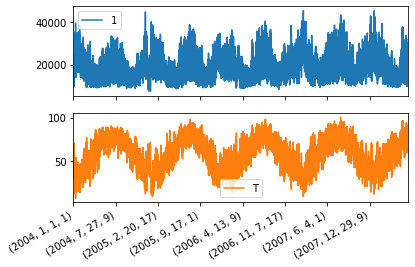

In [433]:
temp[[1, 'T']].plot(subplots=True)

In [512]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(temp[[1, 'T']])

# Using 80% of data for training, 20% for validation.
TRAINING_PERC = 0.80

train_size = int(len(scaled) * TRAINING_PERC)
test_size = len(scaled) - train_size
train_multi, test_multi = scaled[0:train_size, :], scaled[train_size:len(scaled), :]
print("Number of samples training set: " + str((len(train_multi))))
print("Number of samples test set: " + str((len(test_multi))))

Number of samples training set: 31660
Number of samples test set: 7916


In [529]:
def create_dataset_nstep_multi(dataset, window_size = 1, nstep = 1):
    data_x, data_y = [], []
    for i in range(len(dataset) - window_size - nstep - 1):
        sample = dataset[i:(i + window_size), :]
        data_x.append(sample)
        data_y.append(dataset[(i + window_size):(i + window_size + nstep), 0])
    return(np.array(data_x), np.array(data_y))

def create_model_multi(train_X, train_Y, window_size = 1, nstep = 1):
    vanilla_rnn = Sequential()
    vanilla_rnn.add(LSTM(200, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
    vanilla_rnn.add(LSTM(200))
    vanilla_rnn.add(Dense(nstep))
    vanilla_rnn.compile(loss = "mean_squared_error", optimizer = "adam", metrics = ['mse', 'mae', 'mape'])
    return(vanilla_rnn)

def create_model_multi2(train_X, train_Y, window_size = 1, nstep = 1):
    vanilla_rnn = Sequential()
    vanilla_rnn.add(LSTM(5))
    vanilla_rnn.add(Dense(nstep))
    vanilla_rnn.compile(loss = "mean_squared_error", optimizer = "adam", metrics = ['mse', 'mae', 'mape'])
    return(vanilla_rnn)

train_X, train_Y = create_dataset_nstep_multi(train_multi, window_size, 1)
test_X, test_Y = create_dataset_nstep_multi(test_multi, window_size, 1)
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[2], train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[2], test_X.shape[1]))

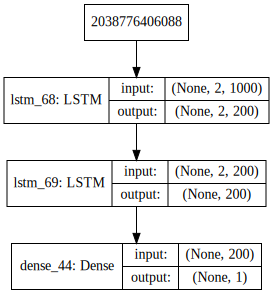

In [530]:
window_size = 500
nstep = 1
multi_rnn = create_model_multi(train_X, train_Y, window_size, nstep)
SVG(model_to_dot(multi_rnn, show_shapes=True).create(prog='dot', format='svg'))

In [531]:
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = multi_rnn.fit(train_X, train_Y, epochs = 100, batch_size = 32, verbose = 2, validation_split=0.15, callbacks=[es])

Train on 26059 samples, validate on 4599 samples
Epoch 1/100
 - 140s - loss: 0.0042 - mean_squared_error: 0.0042 - mean_absolute_error: 0.0471 - mean_absolute_percentage_error: 2733.3254 - val_loss: 0.0022 - val_mean_squared_error: 0.0022 - val_mean_absolute_error: 0.0364 - val_mean_absolute_percentage_error: 13.8920
Epoch 2/100
 - 140s - loss: 0.0015 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0295 - mean_absolute_percentage_error: 1135.4870 - val_loss: 0.0013 - val_mean_squared_error: 0.0013 - val_mean_absolute_error: 0.0286 - val_mean_absolute_percentage_error: 9.6977
Epoch 3/100
 - 121s - loss: 0.0011 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0256 - mean_absolute_percentage_error: 197.9015 - val_loss: 9.1678e-04 - val_mean_squared_error: 9.1678e-04 - val_mean_absolute_error: 0.0226 - val_mean_absolute_percentage_error: 7.7918
Epoch 4/100
 - 140s - loss: 8.3885e-04 - mean_squared_error: 8.3885e-04 - mean_absolute_error: 0.0219 - mean_absolute_percentage_error: 

In [532]:
def get_predict_and_score_multi(model, X, Y):
    # transform the prediction to the original scale
    pred = normalizer.inverse_transform(model.predict(X))
    # transform also the label to the original scale for interpretability
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE
    score = math.sqrt(mean_squared_error(orig_data, pred))
    return(score, pred)

def get_naive_week_predict_and_score_multi(X, Y):
    # transform the prediction to the original scale.
    pred = normalizer.inverse_transform(np.vstack((Y[0:24*7], Y[0:-24*7])))
    # transform also the label to the original scale for interpretability.
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE.
    score = math.sqrt(mean_squared_error(orig_data, pred))
    return(score, pred)

def get_naive_day_predict_and_score_multi(X, Y):
    # transform the prediction to the original scale.
    pred = normalizer.inverse_transform(np.vstack((Y[0:24], Y[0:-24])))
    # transform also the label to the original scale for interpretability.
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE.
    score = math.sqrt(mean_squared_error(orig_data, pred))
    return(score, pred)

def get_naive_hour_predict_and_score_multi(X, Y):
    # transform the prediction to the original scale.
    pred = normalizer.inverse_transform(np.vstack((Y[0, :].reshape(1, -1), Y[0:-1])))
    # transform also the label to the original scale for interpretability.
    orig_data =normalizer.inverse_transform(Y)
    # calculate RMSE.
    score = math.sqrt(mean_squared_error(orig_data, pred))
    return(score, pred)

mse_train, train_predict = get_predict_and_score_multi(multi_rnn, train_X, train_Y)
mse_test, test_predict = get_predict_and_score_multi(multi_rnn, test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train)
print("Test data error: %.2f MSE" % mse_test)
mse_train_naive_week, train_predict_naive_week = get_naive_hour_predict_and_score_multi(train_X, train_Y)
mse_test_naive_week, test_predict_naive_week = get_naive_hour_predict_and_score_multi(test_X, test_Y)
print("Training data error: %.2f MSE" % mse_train_naive_week)
print("Test data error: %.2f MSE" % mse_test_naive_week)

Training data error: 843.52 MSE
Test data error: 858.98 MSE
Training data error: 1442.13 MSE
Test data error: 1454.85 MSE


In [504]:
#normalizer.inverse_transform(multi_rnn.predict(train_X)).shape #(31559, 1)
#normalizer.inverse_transform([train_Y]).shape #(1, 31559)
normalizer.inverse_transform(np.vstack((train_Y[0, :].reshape(1, -1), train_Y[0:-1])))

IndexError: too many indices for array

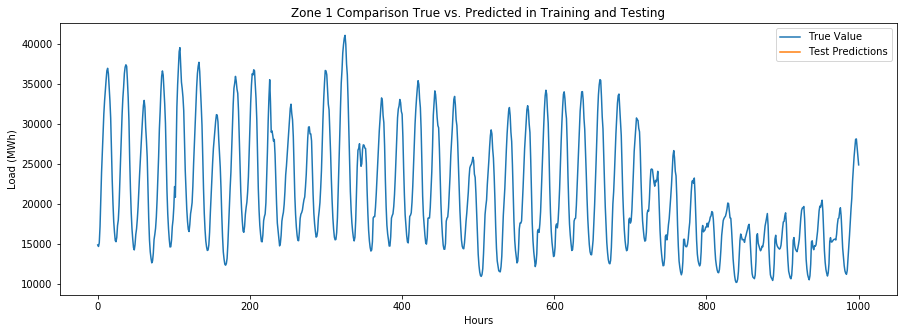

In [496]:
# Create the plot.
plt.figure(figsize = (15, 5))
plt.plot(normalizer.inverse_transform(dataset)[train_size:train_size + window_size + nstep], label = "True Value")
# plt.plot(train_predictions, label = "Training Predictions")
plt.plot(np.concatenate((np.array([np.nan] * window_size), test_predict[0])), label = "Test Predictions")
plt.xlabel("Hours")
plt.ylabel("Load (MWh)")
plt.title("Zone 1 Comparison True vs. Predicted in Training and Testing")
plt.legend()
plt.show()

In [455]:
len(train_predict) - len(dataset)

-8018

In [459]:
# Training predictions.
train_predictions = np.empty_like(dataset)
train_predictions[:, :] = np.nan
train_predictions[window_size:len(train_predict) + window_size, :] = train_predict

# Test predictions.
test_predictions = np.empty_like(dataset)
test_predictions[:, :] = np.nan
test_predictions[len(train_predict) + (window_size * 2) + 1:len(dataset) - 1, :] = test_predict

# Create the plot.
plt.figure(figsize = (15, 5))
plt.plot(normalizer.inverse_transform(dataset), label = "True Value")
#plt.plot(train_predictions, label = "Training Predictions")
plt.plot(test_predictions, label = "Test Predictions")
plt.xlabel("Hours")
plt.ylabel("Load (MWh)")
plt.title("Zone 1 Comparison True vs. Predicted in Training and Testing")
plt.legend()
plt.show()

ValueError: could not broadcast input array from shape (7814,1) into shape (7816,1)

In [440]:
test_predict[0]

array([18959.576], dtype=float32)

In [ ]:
test_predictions=test_predictions.reshape(1,-1)
test_predictions = np.transpose(test_predictions[~np.isnan(test_predictions)])
print(test_predictions)
np.savetxt('./Data/Load_prediction.csv', test_predictions, delimiter=',')